In [3]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Fine-tune a pretrained model

There are significant benefits to using a pretrained model. It reduces computation costs, your carbon footprint, and allows you to use state-of-the-art models without having to train one from scratch. ü§ó Transformers provides access to thousands of pretrained models for a wide range of tasks. When you use a pretrained model, you train it on a dataset specific to your task. This is known as fine-tuning, an incredibly powerful training technique. In this tutorial, you will fine-tune a pretrained model with a deep learning framework of your choice:

* Fine-tune a pretrained model with ü§ó Transformers [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer).
* Fine-tune a pretrained model in TensorFlow with Keras.
* Fine-tune a pretrained model in native PyTorch.

<a id='data-processing'></a>

## Prepare a dataset

Before you can fine-tune a pretrained model, download a dataset and prepare it for training. The previous tutorial showed you how to process data for training, and now you get an opportunity to put those skills to the test!

Begin by loading the [Yelp Reviews](https://huggingface.co/datasets/yelp_review_full) dataset:

In [4]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

df_train_full = pd.read_csv('rusentitweet_train_v2.csv')
df_test = pd.read_csv('rusentitweet_test_v2.csv')

le = preprocessing.LabelEncoder()
le.fit(df_train_full['label'])
df_train_full['label'] = le.transform(df_train_full['label'])
df_test['label'] = le.transform(df_test['label'])

df_train, df_validation = train_test_split(df_train_full, test_size=0.15, random_state=42)

df_validation[['text', 'label']].to_csv('rusentitweet_validation_hf.csv', index=False)
df_train[['text', 'label']].to_csv('rusentitweet_train_hf.csv', index=False)
df_test[['text', 'label']].to_csv('rusentitweet_test_hf.csv', index=False)

In [5]:
le.classes_

array(['negative', 'neutral', 'positive', 'skip', 'speech'], dtype=object)

In [6]:
le.inverse_transform([0, 1, 2, 3, 4])

array(['negative', 'neutral', 'positive', 'skip', 'speech'], dtype=object)

In [7]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={
    'train': 'rusentitweet_train_hf.csv', 
    'test': 'rusentitweet_test_hf.csv', 
    'validation': 'rusentitweet_validation_hf.csv'
    })
dataset

Using custom data configuration default-8f44ab8ca325c113


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8f44ab8ca325c113/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9106
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2679
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1607
    })
})

As you now know, you need a tokenizer to process the text and include a padding and truncation strategy to handle any variable sequence lengths. To process your dataset in one step, use ü§ó Datasets [`map`](https://huggingface.co/docs/datasets/process.html#map) method to apply a preprocessing function over the entire dataset:

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

### Training hyperparameters

Next, create a [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) class which contains all the hyperparameters you can tune as well as flags for activating different training options. For this tutorial you can start with the default training [hyperparameters](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments), but feel free to experiment with these to find your optimal settings.

Specify where to save the checkpoints from your training:

### Metrics

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) does not automatically evaluate model performance during training. You will need to pass [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) a function to compute and report metrics. The ü§ó Datasets library provides a simple [`accuracy`](https://huggingface.co/metrics/accuracy) function you can load with the `load_metric` (see this [tutorial](https://huggingface.co/docs/datasets/metrics.html) for more information) function:

In [9]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Trainer

Create a [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) object with your model, training arguments, training and test datasets, and evaluation function:

Then fine-tune your model by calling [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [10]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report
import numpy as np

EPOCHS = 4
BATHC_SIZE = 32

model_predictions = []

for seed_number in range(3):
  model = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=5)
  training_args = TrainingArguments(
      output_dir="test_trainer", 
      evaluation_strategy="epoch",
      save_strategy="epoch",
      num_train_epochs = EPOCHS,
      overwrite_output_dir = 'True',
      per_device_train_batch_size=BATHC_SIZE,
      warmup_ratio = 0.1,
      learning_rate = 2e-5,
      seed=seed_number,
      metric_for_best_model='f1',
      load_best_model_at_end=True,
    )
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics
  )
  trainer.train()
  predictions = trainer.predict(tokenized_datasets["test"])
  preds = np.argmax(predictions.predictions, axis=-1)
  model_predictions.append(preds)
  print(classification_report(tokenized_datasets["test"]['label'], preds, digits=6, target_names=le.classes_))
  trainer.save_model('trainer_rubert_rusentitweet_seed'+str(seed_number))
  model.save_pretrained('rubert_rusentitweet_seed'+str(seed_number))

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-285
Configuration saved in test_trainer/checkpoint-285/config.json
Model weights saved in test_trainer/checkpoint-285/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-570
Configuration saved in test_trainer/checkpoint-570/config.json
Model weights saved in test_trainer/c

Saving model checkpoint to trainer_rubert_rusentitweet_seed0
Configuration saved in trainer_rubert_rusentitweet_seed0/config.json


              precision    recall  f1-score   support

    negative   0.624679  0.736364  0.675939       660
     neutral   0.711030  0.730337  0.720554      1068
    positive   0.626106  0.585921  0.605348       483
        skip   0.608527  0.425474  0.500797       369
      speech   0.755319  0.717172  0.735751        99

    accuracy                       0.663307      2679
   macro avg   0.665132  0.639054  0.647678      2679
weighted avg   0.661964  0.663307  0.659085      2679



Model weights saved in trainer_rubert_rusentitweet_seed0/pytorch_model.bin
Configuration saved in rubert_rusentitweet_seed0/config.json
Model weights saved in rubert_rusentitweet_seed0/pytorch_model.bin
loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a43261a78bd9edbbf43584c6b00aa94c032301840e532839cb5989362562a5d5.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LA

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-285
Configuration saved in test_trainer/checkpoint-285/config.json
Model weights saved in test_trainer/checkpoint-285/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-570
Configuration saved in test_trainer/checkpoint-570/config.json
Model weights saved in test_trainer/c

Saving model checkpoint to trainer_rubert_rusentitweet_seed1
Configuration saved in trainer_rubert_rusentitweet_seed1/config.json


              precision    recall  f1-score   support

    negative   0.674041  0.692424  0.683109       660
     neutral   0.705575  0.758427  0.731047      1068
    positive   0.587452  0.639752  0.612488       483
        skip   0.658120  0.417344  0.510779       369
      speech   0.774194  0.727273  0.750000        99

    accuracy                       0.672639      2679
   macro avg   0.679876  0.647044  0.657485      2679
weighted avg   0.672509  0.672639  0.668223      2679



Model weights saved in trainer_rubert_rusentitweet_seed1/pytorch_model.bin
Configuration saved in rubert_rusentitweet_seed1/config.json
Model weights saved in rubert_rusentitweet_seed1/pytorch_model.bin
loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a43261a78bd9edbbf43584c6b00aa94c032301840e532839cb5989362562a5d5.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LA

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-285
Configuration saved in test_trainer/checkpoint-285/config.json
Model weights saved in test_trainer/checkpoint-285/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1607
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-570
Configuration saved in test_trainer/checkpoint-570/config.json
Model weights saved in test_trainer/c

Saving model checkpoint to trainer_rubert_rusentitweet_seed2
Configuration saved in trainer_rubert_rusentitweet_seed2/config.json


              precision    recall  f1-score   support

    negative   0.681957  0.675758  0.678843       660
     neutral   0.707845  0.735019  0.721176      1068
    positive   0.596591  0.652174  0.623145       483
        skip   0.583062  0.485095  0.529586       369
      speech   0.827160  0.676768  0.744444        99

    accuracy                       0.668906      2679
   macro avg   0.679323  0.644963  0.659439      2679
weighted avg   0.668631  0.668906  0.667543      2679



Model weights saved in trainer_rubert_rusentitweet_seed2/pytorch_model.bin
Configuration saved in rubert_rusentitweet_seed2/config.json
Model weights saved in rubert_rusentitweet_seed2/pytorch_model.bin


In [13]:
from sklearn.metrics import classification_report
precisions = []
recalls = []
f1s = []
f1ws = []
for predictions in model_predictions:
  precision, recall, f1, _ = precision_recall_fscore_support(tokenized_datasets["test"]['label'], predictions, average='macro')
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)
  precision, recall, f1, _ = precision_recall_fscore_support(tokenized_datasets["test"]['label'], predictions, average='weighted')
  f1ws.append(f1)

print('Avg macro Precision', np.mean(precisions))
print('Avg macro Recall', np.mean(recalls))
print('Avg macro F1', np.mean(f1s))
print('Avg weighted F1', np.mean(f1ws))


Avg macro Precision 0.6747772329026972
Avg macro Recall 0.6436866944877477
Avg macro F1 0.654867154097531
Avg weighted F1 0.6649503767906553


In [15]:
le.classes_

array(['negative', 'neutral', 'positive', 'skip', 'speech'], dtype=object)

In [16]:
!pip install huggingface_hub

In [14]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [17]:
from transformers import AutoModelForSequenceClassification, AutoConfig

In [22]:
model = AutoModelForSequenceClassification.from_pretrained("/content/trainer_rubert_rusentitweet_seed2")
model.push_to_hub("sismetanin/rubert-rusentitweet")
tokenizer.push_to_hub("sismetanin/rubert-rusentitweet")

loading configuration file /content/trainer_rubert_rusentitweet_seed2/config.json
Model config BertConfig {
  "_name_or_path": "/content/trainer_rubert_rusentitweet_seed2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128

Upload file pytorch_model.bin:   0%|          | 3.34k/679M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/sismetanin/rubert-rusentitweet
   dd85507..6ba8174  main -> main

tokenizer config file saved in sismetanin/rubert-rusentitweet/tokenizer_config.json
Special tokens file saved in sismetanin/rubert-rusentitweet/special_tokens_map.json
remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/sismetanin/rubert-rusentitweet
   6ba8174..2ed6d78  main -> main



'https://huggingface.co/sismetanin/rubert-rusentitweet/commit/2ed6d78cb1941168d7eaa0446670b756f6516a34'

In [23]:
from transformers import pipeline
import numpy as np
import torch
from tqdm import tqdm

classification_results = []
classifier = pipeline("sentiment-analysis", model='sismetanin/rubert-rusentitweet', device=0)
for batch in tqdm(np.array_split(tokenized_datasets["test"]["text"], 15)):
  classification_results.extend(classifier(batch.tolist()))

loading configuration file sismetanin/rubert-rusentitweet/config.json
Model config BertConfig {
  "_name_or_path": "sismetanin/rubert-rusentitweet",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "firs

In [24]:
labels_mapper = {
    'LABEL_0': 0,
    'LABEL_1': 1,
    'LABEL_2': 2,
    'LABEL_3': 3,
    'LABEL_4': 4
}
predictions = [labels_mapper[result['label']] for result in classification_results]
print(classification_report(tokenized_datasets["test"]['label'], predictions, digits=6, target_names=le.classes_))

              precision    recall  f1-score   support

    negative   0.681957  0.675758  0.678843       660
     neutral   0.707845  0.735019  0.721176      1068
    positive   0.596591  0.652174  0.623145       483
        skip   0.583062  0.485095  0.529586       369
      speech   0.827160  0.676768  0.744444        99

    accuracy                       0.668906      2679
   macro avg   0.679323  0.644963  0.659439      2679
weighted avg   0.668631  0.668906  0.667543      2679



Normalized confusion matrix


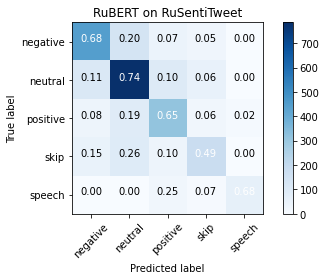

In [27]:
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim([4.5, -0.5])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{0:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.title('RuBERT on RuSentiTweet')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_rusentitweet.png', dpi=300, bbox_inches = "tight")

cnf_matrix = confusion_matrix(tokenized_datasets["test"]['label'], predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=le.classes_, normalize=True,
                    title='Normalized confusion matrix')
plt.show()

In [28]:
df_error_analysis = pd.DataFrame({
    'label': le.inverse_transform(tokenized_datasets["test"]['label']),
    'predicted_label': le.inverse_transform(predictions),
    'text':  tokenized_datasets["test"]['text']
})
df_error_analysis.head()

label predicted_label                                               text
0      skip        negative     –≤—Å–µ –º—ã –ø–æ–º–Ω–∏–º –º–æ–π –∞—Ö—É–π https://t.co/3Kr7yzeYLC
1  positive        positive      —è —Å—á–∏—Ç–∞—é —ç—Ç–æ –º–µ–º –≥–æ–¥–∞ https://t.co/xoVKj5y8Mj
2  positive         neutral  —è–Ω —Ä—É—Å—Å–∫–∏–π –Ω–∞ —Å–æ—Ç–∫—É –≤—Å–µ –∑–∞–ø—è—Ç—ã–µ –≥–¥–µ –Ω–∞–¥–æü§ôüèªüëçüèªüëçüèª...
3      skip            skip               –±—ç–∫ –¥–æ—Ä —Å–æ—Ç–∏ https://t.co/bYCWz4h4Sk
4   neutral            skip     @daria_karapet * —Ç–µ—Ä–∏—è–∫–∏ –±–æ–π–∑ –Ω–∞—á–∏–Ω–∞–µ—Ç –∏–≥—Ä–∞—Ç—å*

In [29]:
from IPython.display import display

for label in df_error_analysis['label'].unique():
  print('True label:', label)
  display(df_error_analysis[(df_error_analysis['label']==label)&(df_error_analysis['predicted_label']!=label)].sample(15, random_state=1))

True label: skip


label predicted_label                                               text
395   skip         neutral  –∫–∞—Ä—Ç–∏–Ω–∫–∞ —Å–º–µ—à–Ω–∞—è –∞ —Å–∏—Ç—É–∞—Ü–∏—è —Å—Ç—Ä–∞—à–Ω–∞—è https://t...
886   skip         neutral                                   @MsBZZZZ –í—ã—Å–æ–∫–∏–π
1560  skip         neutral                                       @lisoff_ –î–∞!
1622  skip          speech                        @redisOchka_aa –ì–æ—Å–ø–æ–¥—É –ë–æ–≥—É
1109  skip         neutral  ¬´–í–µ—Ä–Ω–∏—Ç–µ –ª–µ–∫–∞—Ä—Å—Ç–≤–∞ –±–æ–ª—å–Ω—ã–º –º—É–∫–æ–≤–∏—Å—Ü–∏–¥–æ–∑–æ–º¬ª - –ü...
2139  skip        positive  –û—Ç—Ä–µ–º–æ–Ω—Ç–∏—Ä–æ–≤–∞–ª–∏, —Å–ø–∞—Å–∏–±–æ. –ù–æ –Ω–∞ —Å–ª–µ–¥—É—é—â–∏–π –¥–µ–Ω—å...
457   skip         neutral                  –û—Ç–∫—Ä—ã–≤–∞–π! https://t.co/4lzJ0uAkRP
1399  skip         neutral   @L_Traveler__ @Shisharka_ @nikoJaBitna —ú–æ—Ä–ª–∞ ...
1328  skip         neutral  –£–ª—å—Ç—Ä–∞—á–∏–ª–ª —Å –º–æ–µ–π –¥–µ–≤–æ—á–∫–æ–π @toki_wo_tomare_ ht...
1294  skip        negative  @uyunto —Ç—ã –Ω–µ –ª–æ—Ö—É—à–∫–∞ –õ–û–õ —è —Ç–µ–±–µ –∑–∞–≤–∏–¥—É—é.... —É...
1657  skip        negative  @vasil701 @tass_agency –ú—ã –æ—Ç –≤–∞—à–∏—Ö —Ç–æ–∂–µ –≤ —à–æ–∫–µ...
164   skip        negative  @youpidor66 –Ω—É –ø—Ä–æ—Å—Ç–æ –Ω–∏ —Ä–∞–∑—É –Ω–µ –≤–∏–¥–µ–ª–∞ —á—Ç–æ –±—ã...
990   skip        positive  –ó–∞ —Ç–∞–∫–æ–µ –Ω—ã—Ç—å—ë, –Ω–æ –∑–∞—Ö–æ—Ç–µ–ª–æ—Å—å —Å—é–¥–∞ –Ω–∞–ø–∏—Å–∞—Ç—å —ç—Ç...
2209  skip        positive  @Haid_Rei @Gmih_S_Tea –î–∞ –≤–æ—Ç –º–æ—è —Ç–æ–∂–µ\r\n–ü–û–≠–¢–û...
1849  skip         neutral  @waifuadnstie —Ç–æ–ª—å–∫–æ –ø–æ—Ç–æ–º —Ç—ã —Å–æ–±–µ—Ä—ë—à—å –º–æ–µ —Å–µ—Ä...

True label: positive


label predicted_label  \
619   positive         neutral   
2215  positive         neutral   
66    positive        negative   
2398  positive        negative   
1966  positive         neutral   
182   positive        negative   
1278  positive         neutral   
293   positive            skip   
1381  positive         neutral   
226   positive        negative   
2629  positive         neutral   
1790  positive         neutral   
1587  positive            skip   
2033  positive         neutral   
500   positive         neutral   

                                                   text  
619   —Ö–æ—á—É –Ω–æ–≤—É—é –∑—É–±–Ω—É—é —â–µ—Ç–∫—É, —Ç–∞–∫—É—é –∂–µ –∫—Ä–∞—Å–Ω—É—é, –∫–∞–∫...  
2215  @dima_leemon –í —Ñ–Ω–ª –ø–æ–ª–Ω–æ –º–µ—Å—Ç –¥–ª—è —Ä–æ—Å—Å–∏–π—Å–∫–∏—Ö –∏...  
66    @vladsubbotin –∫—Ä—É—Ç–∞—è –º—ã—à—å, –Ω–æ –º–Ω–µ –Ω–µ –Ω–∞–¥–æ —Å—Ç–æ–ª—å–∫–æ  
2398                              @vmadi_ –û–•–£–ï–ù–ù–ê–Ø –ò–î–ï–ß  
1966  –¢–æ—Ç, –∫—Ç–æ –ø—Ä–∏–¥—É–º–∞–ª –¥–æ—Å—Ç–∞–≤–∫—É –ø—Ä–æ–¥—É–∫—Ç–æ–≤, –≥–µ–Ω–∏–∞–ª–µ–Ω...  
182               –°–∫—É—á–∞—é –∫–∞–∂–¥—ã–π –¥–µ–Ω—å, —á—Ç–æ –º—ã –Ω–µ –≤–∏–¥–∏–º—Å—è  
1278  @oleg_zf –í–∏–¥–∏–º–æ üòÅ –î–∞ –∏ —Ç–æ –≤ —Ñ–∏–∫—Å –ø—Ä–∞–π—Å–µ –Ω–∞–¥–æ –ø...  
293                                   @tuluuna –∏ —Ç–µ–±–µü•∫üíñ  
1381  @jansoulx –≤—ã—à–ª–∞ –∫–ª–∞—Å—Å–Ω–∞—è –∏ –ª–µ–≥–∫–∞—è –¥–æ—Ä–∞–º–∞ –Ω–æ —Ç–∞...  
226             –Ø –ø–æ–ø–∞–ª–∞ –≤ –ø–∏—Ä–∞—Ç—Å–∫–∏–π –±–∏ —Ç–∏–∫—Ç–æ–∫\r\nüëÅÔ∏èüëÑüëÅÔ∏è  
2629    –û—Ç–ø—É—Å–∫ - —ç—Ç–æ, –∫–æ–≥–¥–∞ —Ç—ã –ø–æ–∑–∞–≤—Ç—Ä–∞–∫–∞–ª –¥–∂–∏–Ω —Ç–æ–Ω–∏–∫–æ–º  
1790                           –•–æ—á—É –∫—É–ø–∏—Ç—å –∞–ª—å–±–æ–º......  
1587                          @miss__kennedy –¢—É—É—É—É—É—Ç)0)  
2033     @iffangsia –ú–æ–≥—É –≥–æ–≤–æ—Ä–∏—Ç—å –æ –Ω–∏—Ö –º–∏–ª—å–æ–Ω —á–∞—Å–æ–≤ üòå‚ú®  
500      @Kis__Modar –ü—Ä–æ—á–∏—Ç–∞–ª–∞ –µ–≥–æ –≥–æ–ª–æ—Å–æ–º –∫–æ–Ω–µ—Ü —Ç–≤–∏—Ç–∞üòÇ

True label: neutral


label predicted_label  \
861   neutral        positive   
2406  neutral        negative   
517   neutral        negative   
916   neutral        negative   
2392  neutral        negative   
2080  neutral        positive   
741   neutral            skip   
1182  neutral        negative   
117   neutral        positive   
1709  neutral            skip   
1211  neutral        positive   
1428  neutral        negative   
752   neutral        negative   
960   neutral        positive   
1392  neutral        positive   

                                                   text  
861                  @chunghamygff –Ø –±—ã–ª–∞ –±—ã –Ω–µ –ø—Ä–æ—Ç–∏–≤ü•∫  
2406               @iosonodio_wry –î–ê –ù–ï –•–û–†–ù–ò –Ø –ù–ê –ù–ï–ì–û  
517   @jopka_ogurca @vulnerablekidd @kinda_eboshiki ...  
916   —É—Å—Ç—Ä–∞–∏–≤–∞—é—Å—å –∑–∞–≤—Ç—Ä–∞ —Ä–∞–±–æ—Ç–∞—Ç—å –≤ –∫–æ–ª–ª–µ–¥–∂\r\n—ç—Ç–æ —á...  
2392  –ª–∞–¥–Ω–æ —ç—Ç–æ–≥–æ —Å—Ç–æ–∏–ª–æ –æ–∂–∏–¥–∞—Ç—å\r\n–ø–æ—à–µ–ª —Å–∏–ª—å–Ω—ã–π –ª–∏...  
2080                        @elieniex –∞–ª—Ç–∞–π—Å–∫–∏–π –∫—Ä–∞–πüò≠üò≠üò≠  
741   –¢–∞–∫ –∏ —Ö–æ—á–µ—Ç—Å—è –≤—ã–π—Ç–∏ –Ω–∞ —Å—Ü–µ–Ω—É –û–ª–∏–º–ø–∏–π—Å–∫–æ–≥–æ –∏ –ø—Ä...  
1182  —ç—Ç–æ—Ç —Ç–≤–∏—Ç –Ω–µ —è–≤–ª—è–µ—Ç—Å—è –ø—Ä–∏–∑—ã–≤–æ–º –∫ –¥–µ–π—Å—Ç–≤–∏—è–º –Ω–æ ...  
117   @rostyarb –Ø –º–æ–≥—É –¥–∞–∂–µ –æ—Å–æ–±—ã–π –ø–∞—Ç—Ä–∏–æ—Ç–∏—á–µ—Å–∫–∏–π –Ω–∞...  
1709  @69notyourfriend @jonmsokk @wttwinter –ø—Ö–∞—Ö–∞—Ö–∞ ...  
1211                   –û–∫ —è –ª—é–±–ª—é –º–æ—Ä–æ–∑ –Ω–æ —Ç–∞–∫ –Ω–µ –¥–æ–ª–≥–æ  
1428  @fullhausss –ì—Ä–∞–∂–¥–∞–Ω–∏–Ω—É –ì–µ—Ä–º–∞–Ω–∏–∏ –Ω—É–∂–Ω–æ –ø—Ä–∏–ª–æ–∂–∏—Ç...  
752   –ö—Ç–æ-–Ω–∏–±—É–¥—å, –ø–æ–¥–∞—Ä–∏—Ç–µ –º–Ω–µ –±–∞—Ç–ª –ø–∞—Å –≤ —Ä–∞–¥—É–≥–µ. –ù–µ...  
960                            @PURPLEWHALEARMY –ú–∏–ª–æ—Ç–∞ü•∫  
1392                              @Comrade_Nadia —è–≥–æ–¥–∫–∞

True label: negative


label predicted_label  \
1324  negative         neutral   
2569  negative            skip   
1317  negative            skip   
1320  negative            skip   
565   negative        positive   
305   negative            skip   
615   negative         neutral   
1888  negative         neutral   
34    negative         neutral   
291   negative         neutral   
1456  negative         neutral   
340   negative         neutral   
1176  negative         neutral   
718   negative         neutral   
2031  negative        positive   

                                                   text  
1324  –ö–∞–∂–¥—ã–π –≥—Ä–µ—Ö —Å–∏–ª—å–Ω–µ–µ –∏ —Ö–∏—Ç—Ä–µ–µ –ø—Ä–µ–¥—ã–¥—É—â–µ–≥–æ. –°–Ω–∏–∑...  
2569                              @AlinagonnaDie –°–°–ê–ù–´–ï  
1317            @DmAstaroth –ø–æ–≥–ª—è–¥–∏—Ç–µ –∫–∞, –µ—â–µ –∫–æ–±–µ–Ω–∏—Ç—Å—è  
1320  @nJXCxaqKux6PlP5 @MoskRussia @redsquare2018 –ù–∞...  
565                  –û–•–¢–´–ñ–ë–õ–Ø–¢–¨ https://t.co/azoH6rMiEe  
305                 @makuhaze –ß–¢–û –¨–õ–Ø–¢–¨???? –ú–ê–†–ò–û–õ–ê????  
615    Su ka –≥–¥–µ –º–æ–π –≥–∞–¥—Å –º–µ–Ω—é? https://t.co/J1hFHXcke3  
1888                         @kQTWK2pwWHNHN2l –ê–ª—ë–Ω–∞ –ª–æ—Ö  
34    –ù–ï –ù–£ –í–´ –í–ò–î–ï–õ–ò –ß–ï –¢–í–û–†–Ø–¢???\r\n\r\n#NCT127 #P...  
291   @Voljanin3_0 –ü–æ—á–µ–º—É —Ç—ã –Ω–µ –º–æ–∂–µ—à—å –æ—Ç–≤–µ—Ç–∏—Ç—å –Ω–∞ –≤...  
1456  @sugarmin_0 @_bad_girl_2019 —è –æ—Ç–∫–∞–∑—ã–≤–∞—é—Å—å —Ä–∞–∑–±...  
340        @kapets_ –∫–∞–∫ –º–æ–∂–Ω–æ –µ—Å—Ç—å –ù–ï–ü–û–°–í–Ø–ß–ê–ù–ù–´–ï???????  
1176    @adagamov —Ç—ã –¥–µ–±–∏–ª - —ç—Ç–æ –≤–∏—à–Ω—è , –ª–∏–±–æ —Å–ª–∏–≤–∞ ...  
718   @alleqmi —Ç—ã —á–µ —Å–µ—Ä—å–µ–∑–Ω–æ –¥—É–º–∞–µ—à—å —á—Ç–æ —è —Å–µ–π—á–∞—Å –±...  
2031        @lncnhee –æ–æ–æ–æ–æ, —Ö—É–∏—Ç–∞ –∞–∂ –∑–µ–≤–Ω—É–ª–∞ –∑–∞—Ö–≤—Ö–≤—Ö–≤–∑ü•±

True label: speech


label predicted_label  \
2160  speech            skip   
256   speech        positive   
1600  speech        positive   
1359  speech        positive   
1706  speech        positive   
1298  speech            skip   
1505  speech        positive   
2349  speech            skip   
1453  speech        positive   
1059  speech        positive   
1720  speech        positive   
933   speech        positive   
1466  speech        positive   
2100  speech        positive   
289   speech        positive   

                                                   text  
2160                           @paulcombrig :3 —Å–ø–æ—Å–µ–±–∞!  
256   @_skotina –°–ü–ê–°–ò–ë–û, –¢–ï–ü–ï–†–¨ –Ø –ó–ù–ê–Æ –° –ö–ï–ú –¢–ï–ë–Ø –®–ò...  
1600                        @teaempress_ –û—Ö, —Å–ø–∞—Å–∏–±–∫–∏‚ù§Ô∏è  
1359                             @Toukolina –ø—Ä–∏–≤–µ—Ç—É–ª–∏ üòä  
1706           @urijoo_ –∫–∞–∫ –¥–µ–ª–∞ –º–æ—è —Ö–æ—Ä–æ—à–∞—è?? (‡πë‚ïπœâ‚ïπ‡πë )  
1298  @hopemydad —Ñ—É—Ö –≤—ã–¥—ã—Ö–∞—é —Å–ø–∞—Å–∏–±–æ –ø–æ–ª–∏–Ω–∞ –∞–ª–∏–Ω–∞ –æ–Ω...  
1505  @Volodarskiyy –¢–∞–∫))) –î–æ–±—Ä–æ–≥–æ)) https://t.co/h0...  
2349                                               —Å –Ω–≥  
1453                 @BTS_twt –°–ü–ê–°–ò–ë–û –¢–ï–ë–ï –Ø –¢–ï–ë–Ø –õ–Æ–ë–õ–Æ  
1059                      @johnnyjsyh –Ω–µ –∑–∞ —á—Ç–æ –∑–∞–πüòòüòòüòòüòò  
1720            @adoptedhisha –æ –¥–∞ —è –ø–æ—Å—Ç–∞—Ä–∞—é—Å—å —Å–ø–∞—Å–∏–±–æ  
933   @vdohnovlyat –û–∫ –ê–ª–∏—é—à–∞, –±—É–¥—É –Ω–∞—Å—Ç—Ä–∞–∏–≤–∞—Ç—å —Å–µ–±—è ...  
1466  @wella_ceraptor —Å –Ω–∞—Å—Ç—É–ø–∏–≤—à–∏–º, –∫—Å—Ç–∞—Ç–∏!! —É —Ç–µ–±—è...  
2100                            @mlovin9 –°–ü–û–ö–û–ô–ù–û–ô –ù–û–ß–ò  
289   –ø–æ—Å–≤—è—â–∞—é —Å–≤–æ–µ 25–∫ —Ç–≤–∏—Ç –¥–µ–≤—É—à–∫–∞–º –±–∞—Å–∏—Å—Ç–∞–º –ø–æ–ø –ø...

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [30]:
def get_df_sample(label):
  return df_error_analysis[(df_error_analysis['label']==label)&(df_error_analysis['predicted_label']!=label)].sample(50, random_state=2)

get_df_sample('skip')

label predicted_label                                               text
274   skip         neutral                           @yagodnoe_ochko –Ω–µ –±–æ–π—Å—è
1294  skip        negative  @uyunto —Ç—ã –Ω–µ –ª–æ—Ö—É—à–∫–∞ –õ–û–õ —è —Ç–µ–±–µ –∑–∞–≤–∏–¥—É—é.... —É...
457   skip         neutral                  –û—Ç–∫—Ä—ã–≤–∞–π! https://t.co/4lzJ0uAkRP
62    skip        positive  @kto_are_you @Noname89270295 @Eblankarakuli –û–Ω...
616   skip         neutral                           –ö–∏–º –°–æ–Ω—É —Å–∫–∞–∑–∞–ª ‚ú®‚ú®‚ú®‚ú®—Å–≤–µ—Ç
23    skip         neutral           @yoonjinmadads –î–∏–æ –≠–∫—Å–æ-–ªü•∞ü•∞ü•∞ü•∞ü•∞ü•∞ü•∞ü•∞ü•∞ü•∞ü•∞ü•∞ü•∞ü•∞ü•∞
1174  skip        negative  @kizechka –ù–µ—Å–º–µ—à–Ω—ã–µ —à—É—Ç–∫–∏ —è –Ω–µ –ª–∞–π–∫–∞—é, –Ω–æ —É —Ç–µ...
382   skip         neutral  @DexterMorgan271 @Elena46726081 @valerian_msk ...
2206  skip        positive  ‚Äî Íí∞‚Äß‚Å∫ –¥—Ä—É–∂–µ—Å–∫–æ–µ –Ω–∞–ø–æ–º–∏–Ω–∞–Ω–∏–µ: –µ—Å–ª–∏ –±—ã –Ω–µ –ê–ª–∞–Ω –¢...
1573  skip         neutral  @UNnaSztaszyai5 –ö–∏—Ç–∞–π—Ü—ã —É–∂–µ –º–µ–¥–∏—Ç–∏—Ä—É—é—Ç –Ω–∞ –ø—Ä–æ—â...
2214  skip        positive                         @OEhota –¢—ã –Ω–µ —Ç—É–ø–µ–Ω—å–∫–æ–µü•∫ü•∫ü•∫
1630  skip         neutral  –ú–∞–∫–∑–∞–≤—Ç—Ä–∞–∫: –¥–æ 10\r\n–Ø: –ø—Ä–∏–±—ã–≤–∞—é –≤ –≥–æ—Ä–æ–¥ –≤ 10:...
72    skip         neutral  —É –º–µ–Ω—è –ø–∞—Ä–Ω—ã–µ –æ—Ñ–æ—Ä–º—ã —Å–æ –≤—Å–µ–º–∏ –∏–∑ –∫–≤–∞—Ä—Ç–∏—Ä–Ω–æ–≥–æ –∫...
84    skip         neutral  –£ –ø–∞—Ü–∞–Ω–∞ –±—ã–ª–∏ –Ω–µ –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª—å–Ω–æ –±–æ–ª—å—à–∏–µ —É—à–∏ –∏...
2395  skip         neutral           @odri_bean –ö–æ—Ç–∏–∫–æ–≤\r\n–û–¥—Ä–∏–æ—Å–æ–ª—É\r\n–î–æ–∂–¥—å
28    skip         neutral                                    @jjbaanna –Ω–µ—Ç —è
37    skip         neutral                       @MrBonitas –°–° –Ω–µ –¥–∞–ª–µ–∫–æ —É—à–ª–∏
306   skip        positive  @padadaboy @PPAntoN6 –Ω—É —Ç—ã –Ω–∞–≤–µ—Ä–Ω–æ–µ —à–ª–∞ –≤ –∫–æ—Ä–æ...
730   skip         neutral  –ó–∞ –ø–æ—Å–ª–µ–¥–Ω–∏–µ —Ç—Ä–∏ –≥–æ–¥–∞ –Ω–∏ –æ–¥–Ω–æ–π –Ω–æ—Ä–º–∞–ª—å–Ω–æ–π —Ñ–æ—Ç–∫...
876   skip         neutral  @_Sovyshka_ja –í—Ä—è–¥–ª–∏)\r\n–î–æ–∫ @kusi_pupsiaru  –∏...
675   skip         neutral                            @SICHENGCATB0Y –æ—Ç–Ω–æ—à—É—Å—å
2218  skip         neutral  –í–´–•–í–ê–¢–ò–õ –í –ü–†–ê–ù–ö–ï –û–¢ –ë–õ–û–ì–ï–†–û–í / –ù–ò–ö–ò–¢–ê –ó–õ–ê–¢–û–£–°...
585   skip         neutral  –∫—É—à–∞—é –≤–µ–≥–∞–Ω—Å–∫–æ–µ –º–æ—Ä–æ–∂–µ–Ω–Ω–æ–µ, —Å–ª–µ–∑–∞–º–∏ —É–∂–µ –Ω–µ –∑–∞—Ö...
1976  skip         neutral                         –ù—É —á—Ç–æ –∂–µ —Å –Ω–æ–≤—ã–º –≥–æ–¥–æ–º...
2669  skip         neutral  –£ –∫–∞–∂–¥–æ–π —É–≤–∞–∂–∞—é—â–µ–π —Å–µ–±—è –∂–µ–Ω—â–∏–Ω—ã –Ω–∞ 14 —Ñ–µ–≤—Ä–∞–ª—è ...
886   skip         neutral                                   @MsBZZZZ –í—ã—Å–æ–∫–∏–π
51    skip        positive      @SWTYJNLL –û–ù –¢–ê–ö –°–ú–ê–ß–ù–û –ï–ì–û –®–õ–ï–ü–ù–£–õ –Ø–ù–ù–ê–ê–ê–ê–ê–ê
582   skip        negative    @sofleee @Your__Alpha__ –ë–õ–Ø–¢–¨ –¶–´–¶ –¢–´ –ß–¢–û –í–û–û–ë–©–ï
1547  skip        positive                              @yashawang –±–æ–∂–µ üíîüíîüíîüíîüíî
77    skip         neutral  –ö–∞–∫–æ–µ —É–≤–µ—Ä–µ–Ω–Ω–æ–µ —Ä–µ—à–µ–Ω–∏–µ\r\n-–î–∞?\r\n-–î–∞\r\n(–û–∫–µ...
2290  skip        positive               @cuinthehellsoon –£–∂ –ª—É—á—à–µ —Ç–≤–æ—è –≥—Ä—É–¥—å
1873  skip        negative  @krylata_kotinka –º–æ—è –≤—Ä–æ–¥–µ –ø–µ—Ä–µ—Å—Ç–∞–ª–∞ –ø–∏–∑–¥—ã –Ω–∞ ...
1712  skip        positive                           @astronomysucks —Ö–æ—Ä–æ—à–æ ü•∫
2166  skip         neutral  @Nat_anest @Doodlettae @Slav_Kay –ß—Ç–æ-—Ç–æ –≤—Å–ø–æ–º–Ω...
2153  skip        negative  @nansyrosell –ò —ç—Ç–æ—Ç –∑–≤—É–∫ –ø—Ä–µ–≤—ã—à–µ–Ω–∏—è –≥—Ä–æ–º–∫–æ—Å—Ç–∏ ...
1828  skip        negative  @invnvrts_ —Å–º–µ—à–Ω–æ–µ —Å–∏–∂—É –ø–ª–∞—á—É —Ö–∑ –ø–æ—á–µ–º—É –Ω–∞–≤–µ—Ä–Ω...
2145  skip        positive  @1SDQUC5E4JLflr2 –ë–ß–õ–ê–í–ß–í–Ø–Ø –¢–ê–ö –°–ú–ï–®–ù–û –ó–í–£–ß–ò–¢ –£...
1260  skip         neutral  –ë–æ–π–∫–æ–≤–∞ –∏ –ö–æ–∑–ª–æ–≤—Å–∫–∏–π: —Ä–∞–¥—ã, —á—Ç–æ –≤–æ–∑–≤—Ä–∞—â–∞–µ–º—Å—è –≤...
1239  skip         neutral                         –º–µ–Ω—è—é –æ—Ñ–æ—Ä–º—É –ø–æ—Ç–æ–º—É 

In [31]:
get_df_sample('neutral')

label predicted_label  \
76    neutral        negative   
2112  neutral            skip   
2293  neutral        negative   
1925  neutral        negative   
2488  neutral        negative   
904   neutral        positive   
307   neutral        positive   
2045  neutral        positive   
55    neutral        negative   
1040  neutral        negative   
131   neutral            skip   
2149  neutral            skip   
964   neutral        negative   
265   neutral        positive   
1591  neutral        positive   
257   neutral            skip   
720   neutral        negative   
1447  neutral        negative   
2494  neutral        positive   
797   neutral        positive   
1211  neutral        positive   
1374  neutral            skip   
2571  neutral        positive   
1982  neutral        positive   
741   neutral            skip   
1255  neutral        negative   
1160  neutral        negative   
2471  neutral        positive   
2372  neutral        negative   
117   neutral        positive   
1842  neutral        negative   
447   neutral        negative   
2205  neutral        negative   
1869  neutral        positive   
570   neutral        negative   
1253  neutral        negative   
1419  neutral            skip   
2180  neutral        negative   
1510  neutral        positive   
722   neutral        positive   
101   neutral        positive   
2080  neutral        positive   
1168  neutral        positive   
1055  neutral        positive   
2048  neutral        negative   
1980  neutral        positive   
1866  neutral        negative   
645   neutral        positive   
228   neutral        negative   
1437  neutral        positive   

                                                   text  
76    @J3EhcJjfgGsGQ83 @M_Borzykin –ü—Ä–∏ —á–µ–º —Ç—É—Ç —É–¥–∞—Ä ...  
2112                                 @goldenkookmad –î–ê!  
2293                @pollumy –ü–û–î–û–ñ–î–ò –ù–£ –ú–ù–ï –ö–ê–ó–ê–õ–û–°–¨ –î–ê  
1925                        —è –ø—Ä–æ—Å—Ç–æ —É—Å—Ç–∞–ª–∞ –∏—Ö –ø—Ä—è—Ç–∞—Ç—å.  
2488  @TerakadoTsuuSup –î–∞, —è —Å–µ–π—á–∞—Å –Ω–∞ –¥–∏—Å—Ç–∞–Ω—Ü–∏–æ–Ω–∫–µ,...  
904             @ShionZero —è —Ö–æ—á—É —É–≤–∏–¥–µ—Ç—å —Ç–µ–±—è –≤ —é–±–∫–µü•∫üíï  
307   @Marsiyanka228 –í–û–¢ –¢–ê–ö –°–ú–û–¢–†–ï–õ –ù–ê –ï–ì–û –ü–û–Ø–í–õ–ï–ù–ò...  
2045         @MsKirona –ó–Ω–∞—á–∏—Ç –∂–¥—ë–º. –ó–∞–ª–ø–æ–º –∫–æ–æ–ø –∂–¥—ë—Ç ))  
55    @douknowwhou —ç—Ç–æ –±—É–∫–≤–∞–ª—å–Ω–æ —Ç—ã –º—É—á–∞—á–∞ https://t...  
1040                 –Ω–µ –∑–Ω–∞—é –∫–∞–∫ —è –∫ —ç—Ç–æ–º—É –¥–æ—à–ª–∞ —á–µ—Å—Ç–Ω–æ  
131                                —è —É—Ö–æ–∂—É. –æ–Ω–∞ —á–∏–≥—É–∫–µ—Ä  
2149                                        @kktobm –æ–∫–∫  
964   @yourfinalsin @acid_beer –û –Ω–µ—Ç –æ–Ω–∏ –Ω–∞—à–ª–∏ –º–µ–Ω—è ...  
265                      @Glukoska –ò–∑–≤–µ–Ω–∏, —è —Å–ª—É—á–∞–π–Ω–æ üòê  
1591  –Ω–µ –∏–∑–≤–∏–Ω—è—é—Å—åüóøü§ü\r\n—É –º–µ–Ω—è –∑–∞–∫–æ–Ω—á–∏–ª–∏—Å—å –¥–ª–∏–Ω–Ω—ã–µ –∫...  
257   "—è —Å–∫–æ—Ä–æ—Å—Ç—å"\r\n#–º–µ–º—ã #—é–º–æ—Ä #–∂–∏–∑–∞ #memes #Russ...  
720   @4sbATcclTF691C9 –≤–æ—Ç —á—Ç–æ –∑–Ω–∞—á–∏—Ç, –∫–æ–≥–¥–∞ —á—É–∂–æ–π –Ω...  
1447                               @hzn_pedro –æ–¥–∏–Ω–æ–∫–∏–º*  
2494  –ü–æ—Å–æ–≤–µ—Ç—É–π—Ç–µ –∫–∞–∫–æ–π-—Ç–æ —Å–µ—Ä–∏–∞–ª!!!))) https://t.co...  
797   –ü–∏–ª —è —á—É—Ç–∫–∞ –∏ —Ç–æ –ø–∏–≤–æ, –º–Ω–µ –Ω—É–∂–Ω–æ –±—ã–ª–æ –ø–æ–æ–±—â–∞—Ç—å...  
1211                   –û–∫ —è –ª—é–±–ª—é –º–æ—Ä–æ–∑ –Ω–æ —Ç–∞–∫ –Ω–µ –¥–æ–ª–≥–æ  
1374             @leervii –î–∞ ü•∫üíó https://t.co/3LERP3Lsw7  
2571  @law_tattoo –°–ª—ã—à)) –æ—Ç–∫—Ä–æ–π —Ñ–æ—Ä—Ç–æ—á–∫—É, –≤–ø—É—Å—Ç–∏ —Å–≤–µ...  
1982                            –ê–®–ò–î–û –ù–ê–î–ï–Æ–°–¨ –°–ß–ò–¢–ê–ï–¢–°–ß  
741   –¢–∞–∫ –∏ —Ö–æ—á–µ—Ç—Å—è –≤—ã–π—Ç–∏ –Ω–∞ —Å—Ü–µ–Ω—É –û–ª–∏–º–ø–∏–π—Å–∫–æ–≥–æ –∏ –ø—Ä...  
1255  @dayanat01 –ù—É –æ–Ω–∞ —Ö–æ—Ç—å –±–ª–æ–Ω–¥–∏–Ω–∫–∞, —É –Ω–µ–µ —Ö–æ—Ç—å –∫...  
1160  @_yglerod_ –≠—Ç–æ –Ω–∞–∑—ã–≤–∞–µ—Ç—Å—è –¥–µ–∫–æ–Ω—Å—Ç—Ä—É–∫—Ü–∏—è (–Ω–∞–≤–µ—Ä...  
2471  —Å–¥–µ–ª–∞–µ—à—å                        –æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ\r\...  
2372  @dolly_6ll3 –ú–ê–® –ú–´ –ù–ï

In [33]:
get_df_sample('positive')

label predicted_label  \
656   positive         neutral   
368   positive         neutral   
674   positive         neutral   
738   positive            skip   
205   positive         neutral   
48    positive         neutral   
90    positive          speech   
2416  positive          speech   
1084  positive         neutral   
1060  positive        negative   
22    positive         neutral   
2294  positive          speech   
2370  positive        negative   
2369  positive            skip   
1816  positive        negative   
197   positive          speech   
637   positive        negative   
2232  positive         neutral   
1431  positive        negative   
79    positive        negative   
398   positive         neutral   
1278  positive         neutral   
2343  positive          speech   
1990  positive         neutral   
386   positive         neutral   
1075  positive            skip   
874   positive        negative   
1875  positive        negative   
2548  positive         neutral   
2576  positive          speech   
1899  positive         neutral   
463   positive            skip   
1613  positive        negative   
535   positive        negative   
2589  positive            skip   
1308  positive        negative   
1554  positive         neutral   
659   positive        negative   
2260  positive         neutral   
2411  positive            skip   
226   positive        negative   
2517  positive            skip   
1959  positive         neutral   
1567  positive         neutral   
2476  positive         neutral   
2386  positive          speech   
1190  positive          speech   
1582  positive         neutral   
2341  positive         neutral   
2356  positive         neutral   

                                                   text  
656        –ù–∞ —Å–∞–º–æ–º –¥–µ–ª–µ —è –ª–æ–≤–ª—é —É—Ä—É—Ä—É —Å —ç—Ç–æ–≥–æ –æ–±–ª–∞—á–∫–∞.  
368   –£ –º–µ–Ω—è 1000¬†–ø–æ–¥–ø–∏—Å—á–∏–∫–æ–≤ –Ω–∞ YouTube! #1kcreator...  
674   @An4r2 @glubinniescrepi –¢—ã —á–µ–º —Ç–∞–º? –Ø —Ç–æ–∂–µ —Ö–æ—á—ÉüòÇü§ò  
738   @KHUNAGUEROSEKSI –Ω–µ–µ–µ–µ—Ç —Ç—ã—ã—ã –∫–∞–∫ —Ç—ã –º–æ–∂–µ—à—å —Ç–∞–∫...  
205   @MatchTV –¢–∞–º –∂–µ –ú–∞–ª–∏–Ω–æ–≤—Å–∫–∏–π —â–∞—Å –≤ –ø–æ—Ä—è–¥–∫–µ –ø–æ–ª–Ω...  
48          @Umfcsamregion –Ω—É –≤–æ—Ç –∏ –¥–æ–∂–¥–∞–ª–∏—Å—å. —Å–ø–∞—Å–∏–±–æ.  
90    @GONEFLUDD132 –°–∫–æ—Ä–µ–π—à–µ–≥–æ –≤—ã–∑–¥–æ—Ä–æ–≤–ª–µ–Ω–∏—è –∏ –ø—Ä–∏–≤–µ...  
2416  –í—Å—ë –≤—Å–µ–º —Å–ø–æ–∫–æ–π–Ω–æ–π –Ω–æ—á–∏ üåô https://t.co/eowdd1HdwC  
1084            @dankaloool –Ø –≤ ¬´–∞¬ª,–Ω–æ –ø–æ—à–ª–∞ –±—ã –∫ —Ç–µ–±–µüòé  
1060             —Ñ–∏–ª–æ—Å–æ—Ñ–∏—è –æ—Ç –¥–µ–¥–∞ —Ç–∞–∫ –∏ –ø—Ä–µ—Ç\r\n—É–≤–∞–∂–∞—é  
22    –ü–æ —Å–ª–æ–≤–∞–º —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫–æ–≤, —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å —Ä–æ—Å—Å–∏–π—Å...  
2294                  @jeonbabyx –ø—Ä–∏—è—Ç–Ω–æ –ø–æ–∑–Ω–∞–∫–æ–º–∏—Ç—å—Å—è!  
2370                          @11dewey11 –≤–æ—Ç —ç—Ç–æ –±–∞–ª–¥—ë–∂  
2369                         @youknow_itisya –ê—Ö—Ö–∞—Ö–∞ ü§°ü§°ü§°  
1816  —è —Å–∫—É—á–∞—é –ø–æ —ç–∫—Å–≤–∞–Ω\r\n–∫–æ–≥–¥–∞ —É–∂–µ –ø—Ä–æ–∏–∑–æ–π–¥—ë—Ç —Ç–æ,...  
197             @sasukemybf —Å–ª–∞–¥–∫–∏—Ö —Å–Ω–æ–≤ –º–æ—è —Å–æ—É–ª–º–µ–π—Ç–∫–∞  
637   @Rika_cchi –û–≥–æ, —è –Ω–µ –∑–Ω–∞–ª–∞ —á—Ç–æ –≤ –ú–æ—Å–∫–≤–µ –æ–Ω–æ –µ—Å...  
2232                                  @sbrshv –ü–æ–≤–µ–∑–ª–æ:)  
1431  @watachaneee 12 –Ω–æ—á–∏, —è –∏ —Ç–∞–∫ –∂—Ä–∞—Ç—å —Ö–æ—á—É, —Ç—ã —á...  
79    @vassural –ú–æ–ª–æ–¥—Ü—ã –∫—É–±–∏–Ω—Ü—ã. –ê –º—ã –∏—Ö –≤ 90—ã—Ö –ø—Ä–µ–¥...  
398                                     @else_java –•–∞—Ö–∞  
1278  @oleg_zf –í–∏–¥–∏–º–æ üòÅ –î–∞ –∏ —Ç–æ –≤ —Ñ–∏–∫—Å –ø—Ä–∞–π—Å–µ –Ω–∞–¥–æ –ø...  
2343  @McCreation3 –°–ø–∞—Å–∏–±–æ!! –Ø —Ä–∞–¥–∞, —á—Ç–æ –ø–æ–ª—É—á–∏–ª–æ—Å—å ...  
1990  @ChristineSallot @laliemerald –° –∫–æ–Ω—Ç–∞–∫—Ç–Ω—ã–º —Ä—É–∫...  
386      @SVETALANAKIM –Ø —Ç–æ–∂–µ –ø–æ—Ö—É–¥–µ–ª–∞ —Å–∞–º–∞ –Ω–µ –∑–Ω–∞—è –∫–∞–∫  
1075     —Ç—Ä–µ–¥ –≤–∞–π–¥–∂–∏ –∞—Ä—Ç–∏—Å—Ç—ã –∫–∞–∫ –±–æ–≥–∏ –ñ–ò–í–´–• –≤—ã—Å—Ç—É–ø–ª–µ–Ω–∏–π  
874   –í—Å–µ –º—ã - —Å–æ–≤–µ—Ä—à–µ–Ω–Ω—ã. –ò –≤—Å–µ —Å–∏—Ç—É–∞—Ü–∏–∏ –≤ –Ω–∞—à–µ–π –∂

In [32]:
get_df_sample('positive')

label predicted_label  \
656   positive         neutral   
368   positive         neutral   
674   positive         neutral   
738   positive            skip   
205   positive         neutral   
48    positive         neutral   
90    positive          speech   
2416  positive          speech   
1084  positive         neutral   
1060  positive        negative   
22    positive         neutral   
2294  positive          speech   
2370  positive        negative   
2369  positive            skip   
1816  positive        negative   
197   positive          speech   
637   positive        negative   
2232  positive         neutral   
1431  positive        negative   
79    positive        negative   
398   positive         neutral   
1278  positive         neutral   
2343  positive          speech   
1990  positive         neutral   
386   positive         neutral   
1075  positive            skip   
874   positive        negative   
1875  positive        negative   
2548  positive         neutral   
2576  positive          speech   
1899  positive         neutral   
463   positive            skip   
1613  positive        negative   
535   positive        negative   
2589  positive            skip   
1308  positive        negative   
1554  positive         neutral   
659   positive        negative   
2260  positive         neutral   
2411  positive            skip   
226   positive        negative   
2517  positive            skip   
1959  positive         neutral   
1567  positive         neutral   
2476  positive         neutral   
2386  positive          speech   
1190  positive          speech   
1582  positive         neutral   
2341  positive         neutral   
2356  positive         neutral   

                                                   text  
656        –ù–∞ —Å–∞–º–æ–º –¥–µ–ª–µ —è –ª–æ–≤–ª—é —É—Ä—É—Ä—É —Å —ç—Ç–æ–≥–æ –æ–±–ª–∞—á–∫–∞.  
368   –£ –º–µ–Ω—è 1000¬†–ø–æ–¥–ø–∏—Å—á–∏–∫–æ–≤ –Ω–∞ YouTube! #1kcreator...  
674   @An4r2 @glubinniescrepi –¢—ã —á–µ–º —Ç–∞–º? –Ø —Ç–æ–∂–µ —Ö–æ—á—ÉüòÇü§ò  
738   @KHUNAGUEROSEKSI –Ω–µ–µ–µ–µ—Ç —Ç—ã—ã—ã –∫–∞–∫ —Ç—ã –º–æ–∂–µ—à—å —Ç–∞–∫...  
205   @MatchTV –¢–∞–º –∂–µ –ú–∞–ª–∏–Ω–æ–≤—Å–∫–∏–π —â–∞—Å –≤ –ø–æ—Ä—è–¥–∫–µ –ø–æ–ª–Ω...  
48          @Umfcsamregion –Ω—É –≤–æ—Ç –∏ –¥–æ–∂–¥–∞–ª–∏—Å—å. —Å–ø–∞—Å–∏–±–æ.  
90    @GONEFLUDD132 –°–∫–æ—Ä–µ–π—à–µ–≥–æ –≤—ã–∑–¥–æ—Ä–æ–≤–ª–µ–Ω–∏—è –∏ –ø—Ä–∏–≤–µ...  
2416  –í—Å—ë –≤—Å–µ–º —Å–ø–æ–∫–æ–π–Ω–æ–π –Ω–æ—á–∏ üåô https://t.co/eowdd1HdwC  
1084            @dankaloool –Ø –≤ ¬´–∞¬ª,–Ω–æ –ø–æ—à–ª–∞ –±—ã –∫ —Ç–µ–±–µüòé  
1060             —Ñ–∏–ª–æ—Å–æ—Ñ–∏—è –æ—Ç –¥–µ–¥–∞ —Ç–∞–∫ –∏ –ø—Ä–µ—Ç\r\n—É–≤–∞–∂–∞—é  
22    –ü–æ —Å–ª–æ–≤–∞–º —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫–æ–≤, —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å —Ä–æ—Å—Å–∏–π—Å...  
2294                  @jeonbabyx –ø—Ä–∏—è—Ç–Ω–æ –ø–æ–∑–Ω–∞–∫–æ–º–∏—Ç—å—Å—è!  
2370                          @11dewey11 –≤–æ—Ç —ç—Ç–æ –±–∞–ª–¥—ë–∂  
2369                         @youknow_itisya –ê—Ö—Ö–∞—Ö–∞ ü§°ü§°ü§°  
1816  —è —Å–∫—É—á–∞—é –ø–æ —ç–∫—Å–≤–∞–Ω\r\n–∫–æ–≥–¥–∞ —É–∂–µ –ø—Ä–æ–∏–∑–æ–π–¥—ë—Ç —Ç–æ,...  
197             @sasukemybf —Å–ª–∞–¥–∫–∏—Ö —Å–Ω–æ–≤ –º–æ—è —Å–æ—É–ª–º–µ–π—Ç–∫–∞  
637   @Rika_cchi –û–≥–æ, —è –Ω–µ –∑–Ω–∞–ª–∞ —á—Ç–æ –≤ –ú–æ—Å–∫–≤–µ –æ–Ω–æ –µ—Å...  
2232                                  @sbrshv –ü–æ–≤–µ–∑–ª–æ:)  
1431  @watachaneee 12 –Ω–æ—á–∏, —è –∏ —Ç–∞–∫ –∂—Ä–∞—Ç—å —Ö–æ—á—É, —Ç—ã —á...  
79    @vassural –ú–æ–ª–æ–¥—Ü—ã –∫—É–±–∏–Ω—Ü—ã. –ê –º—ã –∏—Ö –≤ 90—ã—Ö –ø—Ä–µ–¥...  
398                                     @else_java –•–∞—Ö–∞  
1278  @oleg_zf –í–∏–¥–∏–º–æ üòÅ –î–∞ –∏ —Ç–æ –≤ —Ñ–∏–∫—Å –ø—Ä–∞–π—Å–µ –Ω–∞–¥–æ –ø...  
2343  @McCreation3 –°–ø–∞—Å–∏–±–æ!! –Ø —Ä–∞–¥–∞, —á—Ç–æ –ø–æ–ª—É—á–∏–ª–æ—Å—å ...  
1990  @ChristineSallot @laliemerald –° –∫–æ–Ω—Ç–∞–∫—Ç–Ω—ã–º —Ä—É–∫...  
386      @SVETALANAKIM –Ø —Ç–æ–∂–µ –ø–æ—Ö—É–¥–µ–ª–∞ —Å–∞–º–∞ –Ω–µ –∑–Ω–∞—è –∫–∞–∫  
1075     —Ç—Ä–µ–¥ –≤–∞–π–¥–∂–∏ –∞—Ä—Ç–∏—Å—Ç—ã –∫–∞–∫ –±–æ–≥–∏ –ñ–ò–í–´–• –≤—ã—Å—Ç—É–ø–ª–µ–Ω–∏–π  
874   –í—Å–µ –º—ã - —Å–æ–≤–µ—Ä—à–µ–Ω–Ω—ã. –ò –≤—Å–µ —Å–∏—Ç—É–∞—Ü–∏–∏ –≤ –Ω–∞—à–µ–π –∂

In [36]:
get_df_sample('negative')

label predicted_label  \
209   negative         neutral   
1936  negative        positive   
2584  negative         neutral   
128   negative         neutral   
664   negative         neutral   
1640  negative         neutral   
1738  negative         neutral   
2338  negative        positive   
1176  negative         neutral   
284   negative            skip   
91    negative         neutral   
1107  negative            skip   
2182  negative         neutral   
681   negative         neutral   
1726  negative         neutral   
318   negative         neutral   
765   negative        positive   
1752  negative        positive   
235   negative         neutral   
2426  negative        positive   
2521  negative         neutral   
1694  negative        positive   
2053  negative        positive   
442   negative         neutral   
2324  negative        positive   
2653  negative         neutral   
1916  negative         neutral   
1892  negative         neutral   
573   negative         neutral   
225   negative         neutral   
1686  negative        positive   
2282  negative         neutral   
1404  negative        positive   
994   negative            skip   
53    negative         neutral   
258   negative         neutral   
113   negative            skip   
264   negative            skip   
1513  negative        positive   
152   negative         neutral   
358   negative         neutral   
45    negative        positive   
2272  negative        positive   
27    negative         neutral   
2678  negative            skip   
31    negative         neutral   
2052  negative            skip   
135   negative        positive   
908   negative         neutral   
593   negative         neutral   

                                                   text  
209   –∏–Ω—Ç–µ—Ä–µ—Å–Ω—ã–π —Ñ–∞–∫—Ç: —Å–º—ã—Å–ª–∞ –≤ –∫–ª–∏–ø–∞—Ö —Ç—Ö—Ç –±–æ–ª—å—à–µ, —á...  
1936  @d5SayyUAL0rLSBL –°—Ç–æ–ª—å–∫–æ –ª—é–¥–µ–π —Å–º–æ—Ç—Ä—è—Ç –ö–í–ù? –£–¥...  
2584  –°–µ–π—á–∞—Å –∫–∞–∫ –æ–±–Ω–æ–≤–ª—é –æ—Å—å, –∫–∞–∫ –Ω–∞—á–Ω—É –º–∞—Ç–µ—Ä–∏—Ç—å—Å—è –≤...  
128   @anatoliisharii –ê –Ω–∞–¥–æ –±—ã–ª–æ –∫–∞–∫ —Å–µ—Ä–± –ø–µ—Ä–µ–¥ —Ç—Ä–∞...  
664   –ü–ê–ö–ï–¢–ò–ö –ü–û–ú–û–©–ò –û–¢ –ë–ï–°–ü–û–ú–û–©–ù–û–ô –í–õ–ê–°–¢–ò https://t...  
1640  –ó–∞ —Å—É—Ç–∫–∏ –±–æ–ª–µ–µ —à–µ—Å—Ç–∏ —Ç—ã—Å—è—á –±–æ–ª—å–Ω—ã—Ö COVID-19 ht...  
1738  –ù–∞—á–∞–ª–æ –∫–æ–Ω—Ü–∞ –Ω–µ—Ñ—Ç—è–Ω–æ–π –∏–≥–ª—ã.\r\n\r\nhttps://t.c...  
2338  @Capt_Pereira –ò –Ω–µ –±–æ—è—Ç—Å—è –æ–±–æ—Å—Ä–∞—Ç—å—Å—è –æ—Ç —Ä–∞–∑–≤–µ–¥...  
1176    @adagamov —Ç—ã –¥–µ–±–∏–ª - —ç—Ç–æ –≤–∏—à–Ω—è , –ª–∏–±–æ —Å–ª–∏–≤–∞ ...  
284                   @yoongimysweety —è –Ω–µ –∑–Ω–∞—é—é—é—éüò≠üò≠üò≠üò≠üò≠  
91                                 @FSITBS –≤–∏–¥–∏–º–æ –¥–∞ üòîüòî  
1107       —Ç–æ–±–∏ –∏ –∫—É—Ä–∞–º–∞ —Å–æ—Ñ—Ç—è—Ç—Å—è –∫–æ–Ω–µ—Ü —Å–≤–µ—Ç–∞ –±–ª–∏–∑–æ–∫ –¥–∞  
2182  @Dikegodness –ö–æ–Ω–µ—á–Ω–æ –∂–µ —è –Ω–µ –∏–º–µ—é –≤–≤–∏–¥—É —Ö—Ä–æ–Ω–∏—á...  
681                   —Å—Ç—Ä–æ—é —Ç–µ–æ—Ä–∏–∏ –≤–æ—Ç –¥–æ —á–µ–≥–æ —É–≥ –¥–æ–≤—ë–ª  
1726  –í –ê–Ω—Ç–æ–ø–æ–≤–∫–µ –¥–≤–∞ —á–∞—Å–∞ –Ω–µ –±—É–¥–µ—Ç —Å–≤–µ—Ç–∞\r\n\r\n  h...  
318      @N3TE46GBtRd70zM –Ø –≤–æ—Å–ø—Ä–∏–∏–º—á–∏–≤ –∫ –æ–∫—Ä—É–∂–∞—é—â–∏–º :—Å  
765                –ñ–ï–°–¢–¨ –Ø –°–ï–ô–ß–ê–° –ó–ê–ü–õ–ê–ß–£ –ü–†–Ø–ú –ù–ê –£–†–û–ö–ï  
1752               –Ø –£–í–ï–†–ï–ù–ê –û–ù–ò –ü–û–õ–£–ß–ê–¢ –≠–¢–£ –ù–ê–ì–†–ê–î–£ üò≠üëä  
235   –±–æ–∂–µ –¥—É–º–∞–ª–∞ –Ω–∏–∫–æ–≥–¥–∞ –±–æ–ª—å—à–µ –Ω–µ –≤–µ—Ä–Ω—É—Å—å –≤ —Å–≤–æ–π —É...  
2426                                –î–ï–í–û–ß–ö–ò –ß–ï –ó–ê –•–£–ô–ù–Ø  
2521  @rYERCa2qkLW6pg8 @HistoryFoto –ß–µ –æ–ø—è—Ç—å –Ω–∞ —Å–∏–Ω—å–∫–µ?  
1694                 @karkynovv —è —â–∞—Å –∑–∞–ø–ª–∞—á—É –ß–ï–°–¢–ù–ûüòîüò≠ü•∫  
2053     well\r\n—è —Ä–∞—Å–ø–ª–∞–∫–∞–ª–∞—Å—å https://t.co/ochILSox2L  
442   –ª–∞–¥–Ω–æ —Ö–æ—Ç—å –µ—Å—Ç—å –≤—Ä–µ–º—è –ø–æ–¥—É–º–∞—Ç—å –¥–æ –º–∞—è, –Ω–æ —è —á—É...  
2324          –Ω–µ—Ä–≤–Ω–æ –∂–¥—É 20 –º–∏–Ω—É—Ç –≤ –Ω–∞–¥–µ–∂–¥–µ —á—Ç–æ —ç—Ç–æ –í–°–Å  
2653                        @__nanauu__ —Å–∞–º–∞ —Ç—ã –±–ª–∏–Ωüòîüëäüèø  
1916  –∞ 

In [35]:
df_error_analysis[(df_error_analysis['label']=='speech')&(df_error_analysis['predicted_label']!='speech')]

label predicted_label  \
92    speech        positive   
163   speech        positive   
194   speech        positive   
256   speech        positive   
289   speech        positive   
299   speech        positive   
671   speech        positive   
716   speech            skip   
838   speech        positive   
922   speech        positive   
933   speech        positive   
937   speech            skip   
957   speech            skip   
958   speech        positive   
1059  speech        positive   
1245  speech            skip   
1288  speech        positive   
1298  speech            skip   
1359  speech        positive   
1453  speech        positive   
1466  speech        positive   
1505  speech        positive   
1600  speech        positive   
1706  speech        positive   
1720  speech        positive   
1862  speech        positive   
2100  speech        positive   
2160  speech            skip   
2349  speech            skip   
2371  speech        positive   
2473  speech        positive   
2528  speech        positive   

                                                   text  
92    @NRetura –û–±–∞ –¥–∏–∑–∞–π–Ω–∞ –∫—Ä–∞—Å–∏–≤—ã–µ *__*\r\n–°–ø–∞—Å–∏–±–æ ...  
163            @ilowyl –æ –Ω–µ—Ç :(( –ø–æ–ø—Ä–∞–≤–ª—è–π—Å—è —Å–∫–æ—Ä–µ–µ!! ü•∫  
194   @DooLeeHyung –ï—Å–ª–∏ —Ö–æ—á–µ—à—å –º–æ–≥—É –ø–ª–∞—Ç–∏—Ç—å –Ω–æ –µ—Å–ª–∏ ...  
256   @_skotina –°–ü–ê–°–ò–ë–û, –¢–ï–ü–ï–†–¨ –Ø –ó–ù–ê–Æ –° –ö–ï–ú –¢–ï–ë–Ø –®–ò...  
289   –ø–æ—Å–≤—è—â–∞—é —Å–≤–æ–µ 25–∫ —Ç–≤–∏—Ç –¥–µ–≤—É—à–∫–∞–º –±–∞—Å–∏—Å—Ç–∞–º –ø–æ–ø –ø...  
299   @jkmysweetdaddy –¥–æ–±—Ä–æ–µ —É—Ç—Ä–æ üíó\r\n—Å–ª—É—á–∏–ª–æ—Å—å —á—Ç–æ...  
671   @shelomov –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! –ü–µ—Ä–µ–¥–∞–¥–∏–º –≤–∞—à–∏ –ø–æ–∂–µ–ª–∞–Ω...  
716                         @bastardomafiozo —Å–ø–∞—Å–∏–±–æüò≠üò≠üò≠  
838   –ú–∞—Å–∏–∫–∏, –≤—Å–µ—Ö —Å –Ω–∞—Å—Ç—É–ø–∞—é—â–∏–ºüëºüèª‚òÉÔ∏è\r\n–ï—Å—Ç—å –∫—Ç–æ-—Ç–æ ...  
922                            @llen_lu –° –ø–æ—Å—Ç–∞—Ä–µ–Ω–∏–µ–ºüíÖüíÖ  
933   @vdohnovlyat –û–∫ –ê–ª–∏—é—à–∞, –±—É–¥—É –Ω–∞—Å—Ç—Ä–∞–∏–≤–∞—Ç—å —Å–µ–±—è ...  
937     @_Linjing_ –°–ø–∞—Å–∏–±–æüòöüòö‚ù§Ô∏è‚ú® https://t.co/8HjFzSyqhY  
957                        @ebuchiy_dean –ø–∏–≤–µ—Ç –ø–∏–≤–µ—Ç !!  
958   @FatUnicorn_GAY —Å–ø–∞—Å–∏–±–æ –±–æ–ª—å—à–æ–µü•∞ —è –±—É–¥—É —Å—Ç–∞—Ä–∞—Ç...  
1059                      @johnnyjsyh –Ω–µ –∑–∞ —á—Ç–æ –∑–∞–πüòòüòòüòòüòò  
1245                      @vsvoix_ @vihoba –æ–º–≥ –ø—Ä–∏–≤–µ—Çü•∫üíõ  
1288                     @reennegan –°–ü–ê–°–ò–ë–û –Ø –°–¢–ê–†–ê–õ–ê–°–¨  
1298  @hopemydad —Ñ—É—Ö –≤—ã–¥—ã—Ö–∞—é —Å–ø–∞—Å–∏–±–æ –ø–æ–ª–∏–Ω–∞ –∞–ª–∏–Ω–∞ –æ–Ω...  
1359                             @Toukolina –ø—Ä–∏–≤–µ—Ç—É–ª–∏ üòä  
1453                 @BTS_twt –°–ü–ê–°–ò–ë–û –¢–ï–ë–ï –Ø –¢–ï–ë–Ø –õ–Æ–ë–õ–Æ  
1466  @wella_ceraptor —Å –Ω–∞—Å—Ç—É–ø–∏–≤—à–∏–º, –∫—Å—Ç–∞—Ç–∏!! —É —Ç–µ–±—è...  
1505  @Volodarskiyy –¢–∞–∫))) –î–æ–±—Ä–æ–≥–æ)) https://t.co/h0...  
1600                        @teaempress_ –û—Ö, —Å–ø–∞—Å–∏–±–∫–∏‚ù§Ô∏è  
1706           @urijoo_ –∫–∞–∫ –¥–µ–ª–∞ –º–æ—è —Ö–æ—Ä–æ—à–∞—è?? (‡πë‚ïπœâ‚ïπ‡πë )  
1720            @adoptedhisha –æ –¥–∞ —è –ø–æ—Å—Ç–∞—Ä–∞—é—Å—å —Å–ø–∞—Å–∏–±–æ  
1862  –°–∞–º—ã—Ö –ø—Ä–∏—è—Ç–Ω—ã—Ö –∏ —è—Ä–∫–∏—Ö —Å–Ω–æ–≤–∏–¥–µ–Ω–∏–π ‚Äî –ø–∞—Å–∏–±–∫–∏ ht...  
2100                            @mlovin9 –°–ü–û–ö–û–ô–ù–û–ô –ù–û–ß–ò  
2160                           @paulcombrig :3 —Å–ø–æ—Å–µ–±–∞!  
2349                                               —Å –Ω–≥  
2371  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π —Ç–∞—Ç—É—à–µ—á–∫–∞, –¥–∞–≤–Ω–æ –Ω–µ –≤–∏–¥–µ–ª–∏—Å—åüòâüòéüñ§#WeO...  
2473  –∏—Ç–∞–∫, —è —É–∂–µ –ø–æ–π–¥—É —Å–ø–∞—Ç—å, –≤—Å–µ–º —Å–ø–æ–∫–æ–π–Ω–æ –Ω–æ—á–∏!! ...  
2528                              @inkasyka —Å–ø—Å –ª—é–±–∏–º–∞—è